# Multivariate LTSM Time Series Forecasting Model for Market Predictions

In [1]:
#This code was based on Florian Follonier's code available at https://github.com/flo7up/relataly-public-python-tutorials/blob/master/01%20Time%20Series%20Forecasting%20%26%20Regression/007%20Multivariate%20Time%20Series%20Forecasting%20with%20RNNs.ipynb

#This code is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License 
#(https://creativecommons.org/licenses/by-sa/4.0/).

#This work is a modification of the original work by 
#The changes made are adding RandomSearch to identify appropriate hyperparameters and some restructuring and reformatting of the code.
!pip install yfinance

import math
import yfinance as yf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

#Set plot style
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Create dataset
start_date = '1969-11-24'
end_date = '2023-03-01'
stockname = 'hsi'
ticker_symbol = '^HSI'

dataset = yf.download(ticker_symbol, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


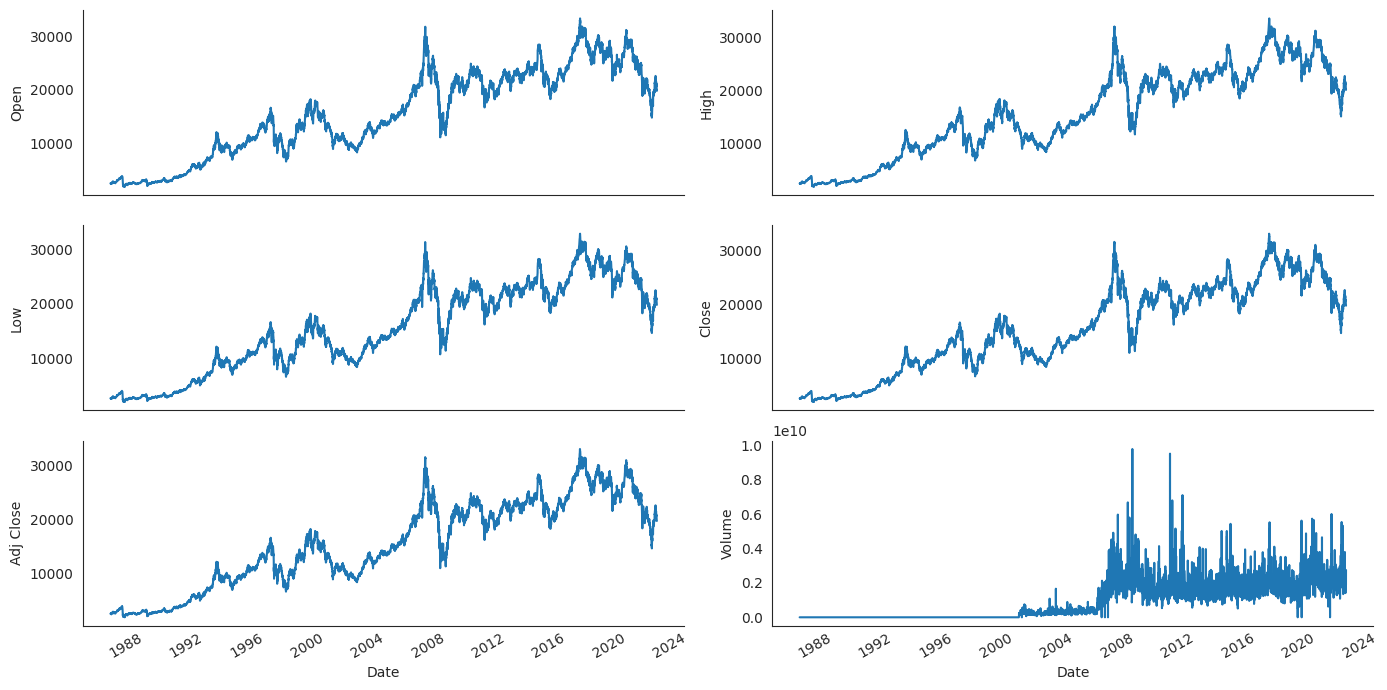

In [3]:
#Plot the market data
dataset.head()
dataset_plot = dataset.copy()
number_of_columns = 2
number_of_rows = int(round(dataset_plot.shape[1] / number_of_columns, 0))

fig, ax = plt.subplots(nrows=number_of_rows, ncols=number_of_columns, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
    sns.lineplot(data=dataset_plot.iloc[:, i], ax=ax)
    ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [4]:
# Preprocessing & feature selection

FEATURES_FILTER_LIST = ['High', 'Low', 'Open', 'Close', 'Volume']  # Features to use for training

# Create a new dataset containing only the selected features
data = pd.DataFrame(dataset.sort_values(by=['Date']).copy())
filtered_dataset = data[FEATURES_FILTER_LIST]

number_of_rows = filtered_dataset.shape[0]

# Add column for predictions and fill with tmp data before scaling
dataset_filtered_ext = filtered_dataset.copy()
dataset_filtered_ext['Prediction'] = dataset_filtered_ext['Close']

# load data into numpy array
np_data_unscaled = np.array(filtered_dataset)
np_data = np.reshape(np_data_unscaled, (number_of_rows, -1))

#Scale data 0-1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

#prediction scaler
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(dataset_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

In [5]:
#Print features, shape of data  & the tail of the filtered dataset
print('FEATURE LIST')
print([feature for feature in FEATURES_FILTER_LIST])

# print dataset tail
print(dataset_filtered_ext.tail())

#print the shape of the numpy array:
print("Shape of data:")
print(np_data.shape)


FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']
                    High           Low          Open         Close  \
Date                                                                 
2023-02-22  20620.980469  20344.859375  20512.490234  20423.839844   
2023-02-23  20601.220703  20323.240234  20339.150391  20351.349609   
2023-02-24  20233.640625  20006.779297  20223.669922  20010.039062   
2023-02-27  20086.529297  19804.560547  19821.029297  19943.509766   
2023-02-28  20185.050781  19783.070312  20020.169922  19785.939453   

                Volume    Prediction  
Date                                  
2023-02-22  1766388300  20423.839844  
2023-02-23  1729748400  20351.349609  
2023-02-24  2061880100  20010.039062  
2023-02-27  1897627300  19943.509766  
2023-02-28  2751875300  19785.939453  
Shape of data:
(8929, 5)


In [8]:
pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 8.5 MB/s eta 0:00:00


In [9]:
from keras_tuner import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Set the sequence length - this is the timeframe used to make a single prediction
window_size = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data



#train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

#todo get length from date

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

testing = np_data_scaled

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - window_size:, :]


# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i - sequence_length:i, :])  # contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_Close])  # contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y


# Generate training data and test data
x_train, y_train = partition_dataset(window_size, train_data)
x_test, y_test = partition_dataset(window_size, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][window_size - 1][index_Close])
print(y_train[0])

def build_model(hp):
    model = Sequential()
    n_neurons = hp.Int('n_neurons',min_value=32, max_value=512, step=32)
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', 
                  optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='project_dir',
    project_name='lstm_tuning')

tuner.search_space_summary()

tuner.search(x_train, y_train, 
             epochs=5, 
             validation_data=(x_test, y_test),
             callbacks=[EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)])

tuner.results_summary()


Trial 5 Complete [01h 45m 22s]
val_loss: 0.0002787074336083606

Best val_loss So Far: 0.0002787074336083606
Total elapsed time: 04h 46m 07s
Results summary
Results in project_dir/lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
n_neurons: 512
learning_rate: 0.001
Score: 0.0002787074336083606

Trial 3 summary
Hyperparameters:
n_neurons: 416
learning_rate: 0.0001
Score: 0.0004109280319729199

Trial 0 summary
Hyperparameters:
n_neurons: 320
learning_rate: 0.0001
Score: 0.0004259398071250568

Trial 1 summary
Hyperparameters:
n_neurons: 224
learning_rate: 0.0001
Score: 0.00046580753405578434

Trial 2 summary
Hyperparameters:
n_neurons: 448
learning_rate: 0.01
Score: 0.010350930814941725


Epoch 1/100
221/221 [==============================] - 236s 1s/step - loss: 0.0011 - val_loss: 4.7975e-04
Epoch 2/100
221/221 [==============================] - 221s 1s/step - loss: 1.0154e-04 - val_loss: 7.6150e-04
Epoch 3/100
221/221 [==============================] - 223s 1s/step - loss: 9.1638e-05 - val_loss: 0.0015
Epoch 4/100
221/221 [==============================] - 222s 1s/step - loss: 7.6835e-05 - val_loss: 2.3101e-04
Epoch 5/100
221/221 [==============================] - 221s 1000ms/step - loss: 7.4897e-05 - val_loss: 4.8794e-04
Epoch 6/100
221/221 [==============================] - 222s 1s/step - loss: 6.9566e-05 - val_loss: 0.0039
Epoch 7/100
221/221 [==============================] - 217s 981ms/step - loss: 8.8604e-05 - val_loss: 2.6799e-04
Epoch 8/100
221/221 [==============================] - 218s 987ms/step - loss: 5.5427e-05 - val_loss: 1.6390e-04
Epoch 9/100
221/221 [==============================] - 225s 1s/step - loss: 6.5190e-05 - val_loss: 2.0470e-04
Epoch 10/100

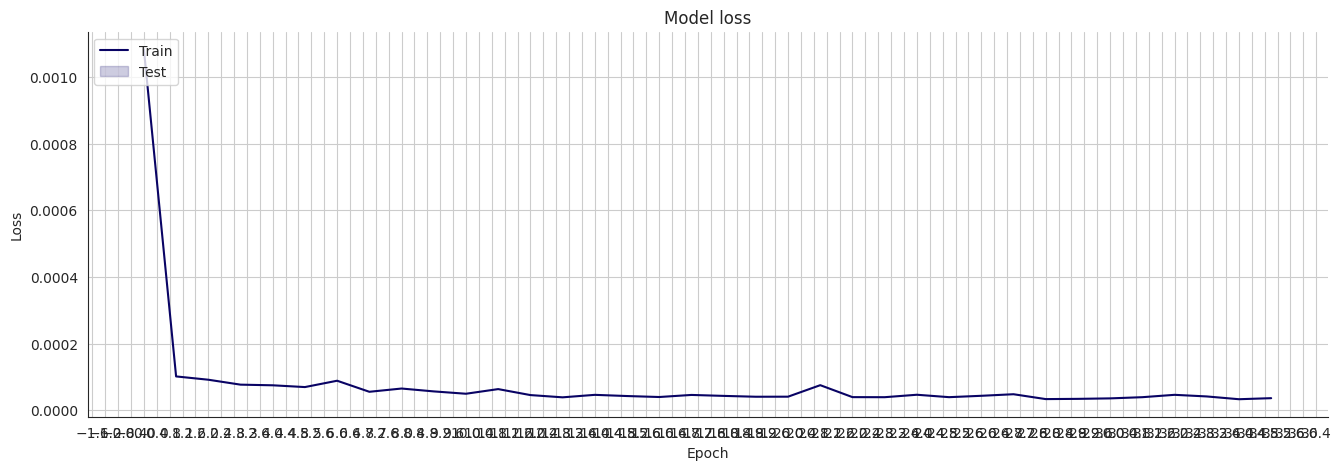

In [21]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model
epochs = 100  
history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)])

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

(7094, 50, 5) (7094,)
(1785, 50, 5) (1785,)
0.02478308949297965
0.02478308949297965
512 50 5
Epoch 1/100
444/444 [==============================] - 697s 2s/step - loss: 0.0012 - val_loss: 3.1568e-04
Epoch 2/100
444/444 [==============================] - 684s 2s/step - loss: 2.0132e-04 - val_loss: 6.8869e-04
Epoch 3/100
444/444 [==============================] - 685s 2s/step - loss: 1.8350e-04 - val_loss: 1.9818e-04
Epoch 4/100
444/444 [==============================] - 680s 2s/step - loss: 1.5916e-04 - val_loss: 2.6139e-04
Epoch 5/100
444/444 [==============================] - 671s 2s/step - loss: 1.6327e-04 - val_loss: 2.6609e-04
Epoch 6/100
444/444 [==============================] - 680s 2s/step - loss: 1.1760e-04 - val_loss: 1.8130e-04
Epoch 7/100
444/444 [==============================] - 665s 1s/step - loss: 1.0226e-04 - val_loss: 2.2637e-04
Epoch 8/100
444/444 [==============================] - 668s 2s/step - loss: 9.8211e-05 - val_loss: 2.6337e-04
Epoch 9/100
444/444 [==========

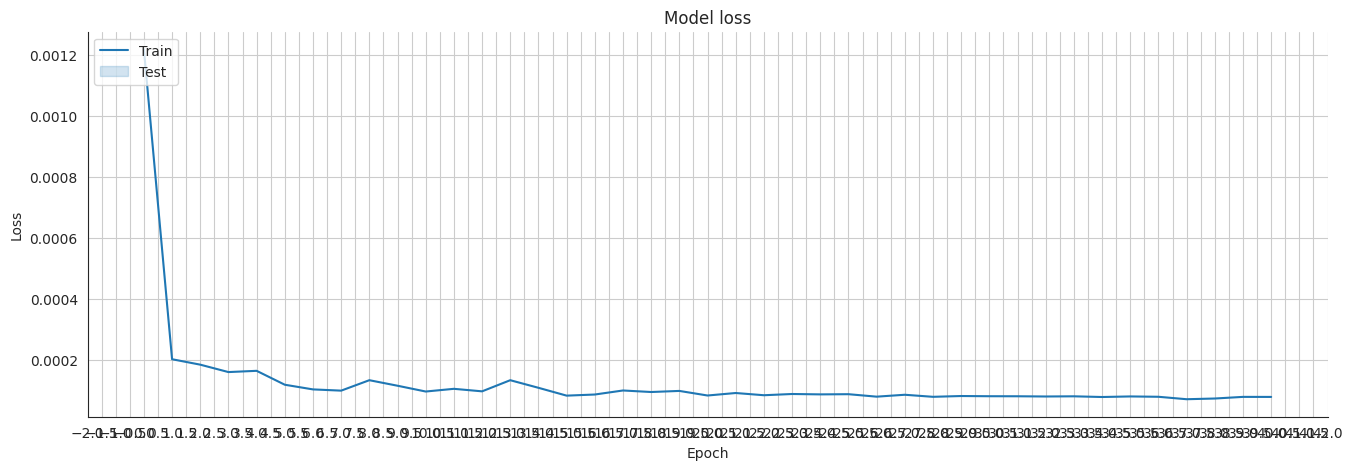

In [6]:
#Model training for manual input of parameters if needed
from tensorflow.keras.optimizers import Adam

# Set the sequence length - this is the timeframe used to make a single prediction
window_size = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data



#train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

#todo get length from date

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

testing = np_data_scaled

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - window_size:, :]


# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i - sequence_length:i, :])  # contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_Close])  # contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y


# Generate training data and test data
x_train, y_train = partition_dataset(window_size, train_data)
x_test, y_test = partition_dataset(window_size, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][window_size - 1][index_Close])
print(y_train[0])

# Model Training

# Configure the neural network model
model = Sequential()

# Model with n_neurons = input shape Timestamps, each with x_train.shape[2] variables
n_neurons = 512
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))
learning_rate = 0.001
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, start_from_epoch=10,restore_best_weights=True)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, callbacks=[early_stop],
                    validation_data=(x_test, y_test)
                    )


# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

56/56 [==============================] - 18s 302ms/step
Median Absolute Error (MAE): 238.49
Mean Absolute Percentage Error (MAPE): 0.98 %
Median Absolute Percentage Error (MDAPE): 0.72 %


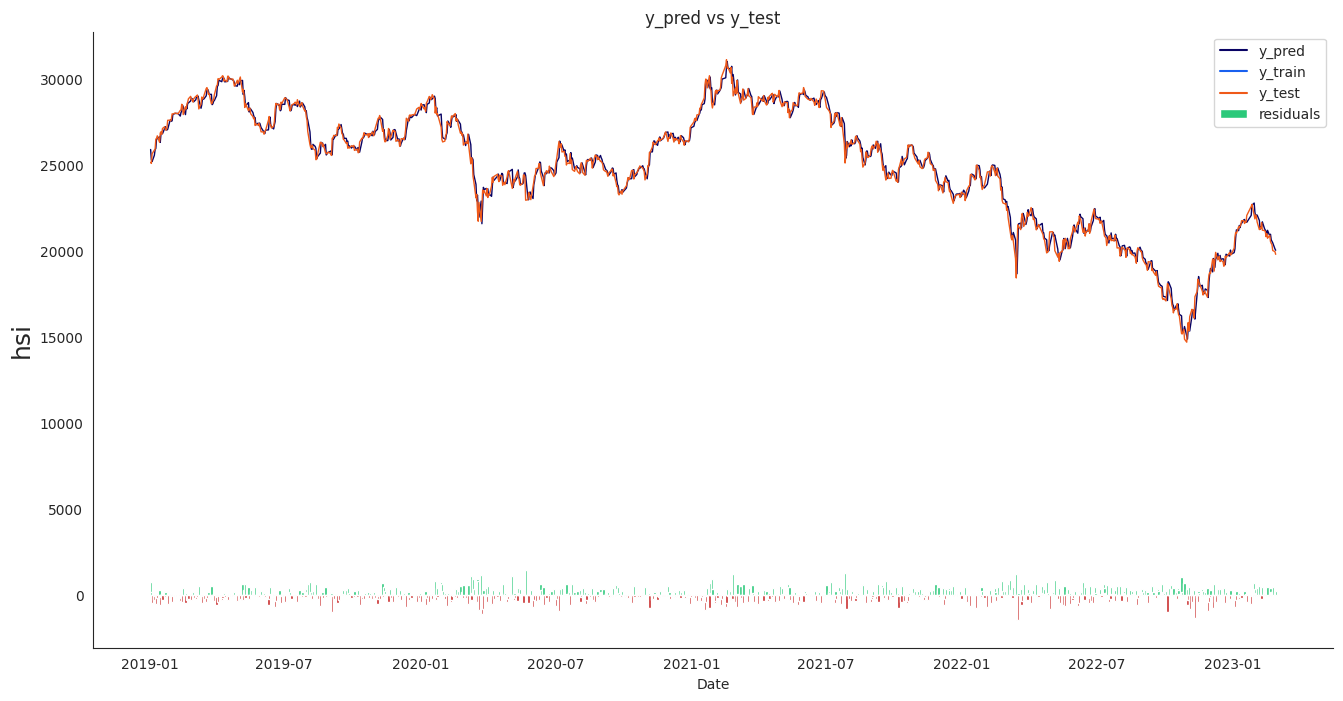

In [7]:
# Evaluate Model Performance

# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred) / y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred) / y_test_unscaled))) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

# The date from which on the date is displayed
display_start_date = "2019-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(dataset_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(dataset_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3,
        label='residuals', color=df_sub)
plt.legend()
plt.show()

In [8]:
#Save the predictions to file
from google.colab import files

file_name = 'LSTM_predictions_'+stockname +'_' +start_date +'_' +end_date + '.csv'


valid.to_csv(file_name, index=False)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Load the CSV file
df = pd.read_csv('LSTM_predictions_hsi_1969-11-24_2023-03-01.csv') 

# Extract the y_test and y_pred columns
y_test = df['y_test'].values
y_pred = df['y_pred'].values

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test, y_pred) / y_test))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test, y_pred) / y_test))) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')


Median Absolute Error (MAE): 238.49
Mean Absolute Percentage Error (MAPE): 0.98 %
Median Absolute Percentage Error (MDAPE): 0.72 %
